# LLM for Clustering

# Data Exploration

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
try:
    import hdbscan
    HAS_HDBSCAN = True
except Exception:
    HAS_HDBSCAN = False
from sklearn.metrics import silhouette_score

In [3]:
df= pd.read_csv('./Data/PIE_data_with_context.csv',sep=';')

In [4]:
df.head()

,Unnamed: 0,F_SESSION,F_START_FRAME,F_END_FRAME,F_DURATION,FIRST_WORD_INDEX,SECOND_WORD_INDEX,THIRD_WORD_INDEX,session,k_aircraft,k_operator,k_mission
0,0,3152409,742,789,00:00:24.000,3.0,10.0,285.0,3152409,41622,81,1
1,1,3152409,790,855,00:00:33.000,3.0,75.0,281.0,3152409,41622,81,1
2,2,3152409,856,965,00:00:55.000,3.0,10.0,8.0,3152409,41622,81,1
3,3,3152409,966,967,00:00:01.000,3.0,10.0,155.0,3152409,41622,81,1
4,4,3152409,968,1001,00:00:17.000,3.0,75.0,146.0,3152409,41622,81,1


# Statistics

In [5]:
import pandas as pd

# --- 1) S'assurer que la durée est bien en secondes ---
df_tmp = df.copy()

# Convertir F_DURATION en secondes
df_tmp["F_DURATION"] = pd.to_timedelta(df_tmp["F_DURATION"], errors="coerce")
df_tmp["duration_sec"] = df_tmp["F_DURATION"].dt.total_seconds()

# --- 2) Nombre de vols (nb F_SESSION uniques) ---
nb_vols = df_tmp["F_SESSION"].nunique()

# --- 3) Durée moyenne et max par vol ---
durations_per_flight = (
    df_tmp.groupby("F_SESSION")["duration_sec"]
    .sum()
    .dropna()
)

duree_moyenne = durations_per_flight.mean()
duree_max = durations_per_flight.max()

# --- 4) Nombre de valeurs uniques par niveau ---
unique_first = df_tmp["FIRST_WORD_INDEX"].nunique()
unique_second = df_tmp["SECOND_WORD_INDEX"].nunique()
unique_third = df_tmp["THIRD_WORD_INDEX"].nunique()

# --- 5) Affichage clair ---
print("====== STATISTIQUES DATASET ======")
print(f"Nombre de vols (F_SESSION) : {nb_vols}")
print(f"Durée moyenne d'un vol (sec) : {duree_moyenne:.2f}")
print(f"Durée max d'un vol (sec) : {duree_max:.2f}")
print()
print("Valeurs uniques :")
print(f"FIRST_WORD_INDEX  : {unique_first}")
print(f"SECOND_WORD_INDEX : {unique_second}")
print(f"THIRD_WORD_INDEX  : {unique_third}")
print("\nDistribution des durées par vol :")
print(durations_per_flight.describe())

====== STATISTIQUES DATASET ======
Nombre de vols (F_SESSION) : 1845
Durée moyenne d'un vol (sec) : 8062.19
Durée max d'un vol (sec) : 19989.50

Valeurs uniques :
FIRST_WORD_INDEX  : 12
SECOND_WORD_INDEX : 976
THIRD_WORD_INDEX  : 1206

Distribution des durées par vol :
count     1845.000000
mean      8062.191870
std       3114.956567
min          0.500000
25%       5940.500000
50%       8058.000000
75%       9683.500000
max      19989.500000
Name: duration_sec, dtype: float64


# Model

In [13]:
# ---------- 1) construire sequences (texte par vol) ----------
def build_sequences_compact(df, use_third=False, sep_event=" | "):
    d = df.copy()
    d = d.sort_values(["F_SESSION", "F_START_FRAME"])

    d["F_DURATION"] = pd.to_timedelta(d["F_DURATION"], errors="coerce")
    d["duration_sec"] = d["F_DURATION"].dt.total_seconds().fillna(0)

    # bins durée (coarse)
    bins = [0, 30, 120, 600, 20000, np.inf]
    labels = ["S", "M", "L", "XL", "XXL"]
    d["dur_bin"] = pd.cut(d["duration_sec"], bins=bins, labels=labels, right=False)

    #  pondérer FIRST (répété 2x)
    if use_third:
        d["token"] = (
            "FIRST_" + d["FIRST_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "FIRST_" + d["FIRST_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "P2_" + d["SECOND_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "P3_" + d["THIRD_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "D_" + d["dur_bin"].astype(str)
        )
    else:
        d["token"] = (
            "FIRST_" + d["FIRST_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "FIRST_" + d["FIRST_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "P2_" + d["SECOND_WORD_INDEX"].astype("Int64").astype(str) + " " +
            "D_" + d["dur_bin"].astype(str)
        )

    sequences = d.groupby("F_SESSION")["token"].apply(lambda x: sep_event.join(x))
    return sequences

In [ ]:
# # ---------- 2) chunking + pooling (ton code) ----------
# def chunk_events(text, sep=" | ", chunk_size=40):
#     events = text.split(sep)
#     return [sep.join(events[i:i+chunk_size]) for i in range(0, len(events), chunk_size)]

# def encode_flights_chunked(sequences: pd.Series, model, chunk_size=40, sep=" | "):
#     flight_ids = sequences.index.tolist()
#     all_chunks = []
#     chunk_owner = []

#     for fid, txt in zip(flight_ids, sequences.tolist()):
#         ch = chunk_events(txt, sep=sep, chunk_size=chunk_size)
#         all_chunks.extend(ch)
#         chunk_owner.extend([fid]*len(ch))

#     chunk_emb = model.encode(all_chunks, show_progress_bar=True)
#     chunk_emb = normalize(np.asarray(chunk_emb, dtype=np.float32))

#     owners = np.array(chunk_owner)
#     emb_dim = chunk_emb.shape[1]
#     flight_emb = np.zeros((len(flight_ids), emb_dim), dtype=np.float32)

#     for i, fid in enumerate(flight_ids):
#         mask = owners == fid
#         flight_emb[i] = chunk_emb[mask].mean(axis=0)

#     return normalize(flight_emb)


# # ---------- 3) run ----------
# sequences = build_sequences_compact(df, use_third=False)
# model = SentenceTransformer("all-MiniLM-L6-v2")

# X_text = encode_flights_chunked(sequences, model, chunk_size=40)

# print("X_text shape:", X_text.shape)  # (1845, 384) normalement
# np.save("X_text.npy", X_text)
# np.save("labels.npy", labels)

In [8]:
X_text = np.load("X_text.npy")
labels = np.load("labels.npy")

   K  Silhouette (↑)  Calinski-Harabasz (↑)  Davies-Bouldin (↓)
2  4        0.152428             550.844055            1.510464
0  2        0.150326             216.534256            2.273334
1  3        0.149523             627.082336            1.614162
3  5        0.134954             467.410095            1.683793
5  7        0.113827             395.779480            1.674546


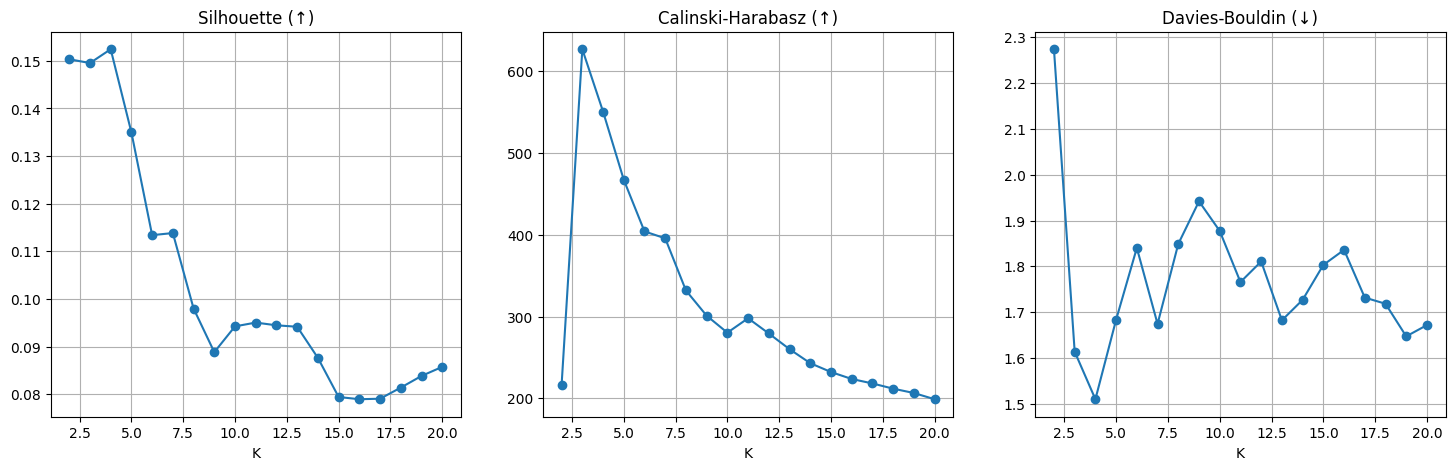

Best K (Silhouette): 4
Best K (Calinski-Harabasz): 3
Best K (Davies-Bouldin): 4


In [10]:
inertias = []
sil_scores = []
ch_scores = []
db_scores = []

Ks = range(2, 21)

for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_k = km.fit_predict(X_text)
    
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_text, labels_k))
    ch_scores.append(calinski_harabasz_score(X_text, labels_k))
    db_scores.append(davies_bouldin_score(X_text, labels_k))

# ----- Tableau résumé -----
scores_df = pd.DataFrame({
    "K": list(Ks),
    "Silhouette (↑)": sil_scores,
    "Calinski-Harabasz (↑)": ch_scores,
    "Davies-Bouldin (↓)": db_scores,
})

print(scores_df.sort_values("Silhouette (↑)", ascending=False).head())

# ----- Graphiques -----
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Silhouette
axes[0].plot(list(Ks), sil_scores, marker="o")
axes[0].set_title("Silhouette (↑)")
axes[0].set_xlabel("K")
axes[0].grid(True)

# Calinski-Harabasz
axes[1].plot(list(Ks), ch_scores, marker="o")
axes[1].set_title("Calinski-Harabasz (↑)")
axes[1].set_xlabel("K")
axes[1].grid(True)

# Davies-Bouldin
axes[2].plot(list(Ks), db_scores, marker="o")
axes[2].set_title("Davies-Bouldin (↓)")
axes[2].set_xlabel("K")
axes[2].grid(True)

plt.show()

# ----- Choix automatique (exemple basé sur silhouette) -----
best_k_sil = Ks[int(np.argmax(sil_scores))]
best_k_ch = Ks[int(np.argmax(ch_scores))]
best_k_db = Ks[int(np.argmin(db_scores))]

print("Best K (Silhouette):", best_k_sil)
print("Best K (Calinski-Harabasz):", best_k_ch)
print("Best K (Davies-Bouldin):", best_k_db)

In [14]:
df_tmp = df.copy()

# convertir durée
df_tmp["F_DURATION"] = pd.to_timedelta(df_tmp["F_DURATION"], errors="coerce")
df_tmp["duration_sec"] = df_tmp["F_DURATION"].dt.total_seconds()

df_meta = (
    df_tmp.groupby("F_SESSION", as_index=False)
    .agg(
        total_duration_sec=("duration_sec", "sum"),
        k_aircraft=("k_aircraft", "first"),
        k_operator=("k_operator", "first"),
        k_mission=("k_mission", "first"),
    )
)
sequences = build_sequences_compact(df)
df_meta.head()

,F_SESSION,total_duration_sec,k_aircraft,k_operator,k_mission
0,3130311,5693.5,46852,20,-2
1,3130519,7617.0,46450,3,1
2,3130827,9767.5,50826,3,1
3,3131023,8381.0,41620,83,1
4,3131064,5307.5,50670,3,1


In [15]:
# 2) Construire df_clusters (labels = tes labels KMeans)
df_clusters = pd.DataFrame({
    "F_SESSION": sequences.index,   # index des vols
    "cluster": labels
})

# 3) Merge une seule fois
tmp = df_clusters.merge(df_meta, on="F_SESSION", how="left")

print(tmp.head())
print("Colonnes tmp:", tmp.columns.tolist())

   F_SESSION  cluster  total_duration_sec  k_aircraft  k_operator  k_mission
0    3130311        0              5693.5       46852          20         -2
1    3130519        1              7617.0       46450           3          1
2    3130827        0              9767.5       50826           3          1
3    3131023        3              8381.0       41620          83          1
4    3131064        1              5307.5       50670           3          1
Colonnes tmp: ['F_SESSION', 'cluster', 'total_duration_sec', 'k_aircraft', 'k_operator', 'k_mission']


In [16]:
print("\n===== k_mission =====")
pd.crosstab(tmp["cluster"], tmp["k_mission"], normalize="index").round(3)


===== k_mission =====


k_mission,-2,1,3,4
cluster,,,,
0,0.121,0.853,0.026,0.000
1,0.006,0.970,0.022,0.003
2,0.000,1.000,0.000,0.000
3,0.218,0.696,0.086,0.000


In [17]:
print("\n===== k_operator =====")
pd.crosstab(tmp["cluster"], tmp["k_operator"], normalize="index").round(3)


===== k_operator =====


k_operator,3,10,12,20,23,81,83,112,161,277,298,303,335,339,394
cluster,,,,,,,,,,,,,,,
0,0.173,0.076,0.012,0.120,0.002,0.168,0.152,0.062,0.055,0.002,0.096,0.006,0.035,0.006,0.036
1,0.174,0.113,0.013,0.006,0.003,0.237,0.251,0.017,0.048,0.001,0.048,0.004,0.029,0.003,0.052
2,0.200,0.000,0.000,0.000,0.000,0.300,0.100,0.100,0.200,0.000,0.000,0.000,0.100,0.000,0.000
3,0.078,0.062,0.051,0.216,0.002,0.062,0.370,0.055,0.000,0.010,0.031,0.018,0.021,0.006,0.018


In [18]:
print("\n===== k_aircraft =====")
pd.crosstab(tmp["cluster"], tmp["k_aircraft"], normalize="index").round(3)


===== k_aircraft =====


k_aircraft,39023,41559,41560,41619,41620,41621,41622,41623,41624,45344,...,52524,54674,54806,54808,54809,54811,56578,56585,56592,56593
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.026,0.027,0.005,0.005,0.017,0.015,0.026,0.041,0.014,0.006,...,0.023,0.006,0.035,0.000,0.002,0.008,0.000,0.008,0.002,0.000
1,0.012,0.019,0.025,0.007,0.033,0.032,0.030,0.042,0.038,0.000,...,0.046,0.003,0.046,0.001,0.004,0.036,0.001,0.001,0.000,0.003
2,0.000,0.000,0.000,0.000,0.000,0.000,0.200,0.100,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.012,0.014,0.000,0.002,0.068,0.066,0.010,0.000,0.008,0.010,...,0.074,0.006,0.008,0.002,0.008,0.014,0.004,0.021,0.002,0.000


In [19]:
print("\n===== Durée par cluster =====")
print(
    tmp.groupby("cluster")["total_duration_sec"]
       .describe()[["mean","std","min","25%","50%","75%","max"]]
       .round(1)
)


===== Durée par cluster =====
           mean     std     min     25%     50%      75%      max
cluster                                                          
0        7687.3  3160.1   652.0  5487.0  7571.0   9529.0  18076.0
1        9028.0  2912.3   999.0  7557.5  8752.5  10300.5  19989.5
2         176.8   280.4     0.5     3.6    81.8    220.4    912.0
3        7364.9  2829.7  1682.5  5097.2  7756.5   8733.8  18572.5


# Visualisation

### PCA

In [25]:
# Si besoin (une fois) :
# uv pip install plotly

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import plotly.express as px

# PCA 3D
pca = PCA(n_components=3, random_state=42)
X_pca3 = pca.fit_transform(X_text)

# F_SESSION (pour hover)
if "sequences" in globals():
    flight_ids = sequences.index.values
# elif "flight_ids" in globals():
#     flight_ids = np.array(flight_ids)
# else:
#     flight_ids = np.arange(len(labels))

plot_df = pd.DataFrame({
    "PC1": X_pca3[:, 0],
    "PC2": X_pca3[:, 1],
    "PC3": X_pca3[:, 2],
    "cluster": labels.astype(int),
    "F_SESSION": flight_ids,
})

# join meta si dispo (tmp = df_clusters.merge(df_meta, on="F_SESSION"))
if "tmp" in globals() and "F_SESSION" in tmp.columns:
    plot_df["F_SESSION"] = pd.to_numeric(plot_df["F_SESSION"], errors="coerce")
    meta = tmp.drop_duplicates("F_SESSION").copy()
    meta["F_SESSION"] = pd.to_numeric(meta["F_SESSION"], errors="coerce")
    meta = meta.drop(columns=["cluster"], errors="ignore")
    plot_df = plot_df.merge(meta, on="F_SESSION", how="left")

plot_df["F_SESSION_str"] = plot_df["F_SESSION"].astype(str)

hover_cols = [c for c in ["F_SESSION_str", "total_duration_sec", "k_operator", "k_aircraft", "k_mission"] if c in plot_df.columns]

fig = px.scatter_3d(
    plot_df,
    x="PC1", y="PC2", z="PC3",
    color="cluster",
    hover_data=hover_cols,
    title="PCA 3D interactive — Clusters de vols"
)

fig.update_traces(marker=dict(size=4))
fig.show()

### UMAP

In [24]:
import umap.umap_ as umap
import pandas as pd
import numpy as np
import plotly.express as px

# UMAP 3D
reducer3d = umap.UMAP(n_neighbors=30, min_dist=0.2, n_components=3, random_state=42)
X_umap3 = reducer3d.fit_transform(X_text)

# ---- récupérer les flight_ids ----
if "sequences" in globals():
    flight_ids = sequences.index.values
elif "flight_ids" in globals():
    flight_ids = np.array(flight_ids)
else:
    flight_ids = np.arange(len(labels))

# convertir proprement en pandas Series (pour utiliser Int64)
flight_ids_s = pd.Series(flight_ids)
flight_ids_num = pd.to_numeric(flight_ids_s, errors="coerce").astype("Int64")  # OK ici

plot_df = pd.DataFrame({
    "F_SESSION": flight_ids_num,     # pandas Series Int64
    "UMAP1": X_umap3[:, 0],
    "UMAP2": X_umap3[:, 1],
    "UMAP3": X_umap3[:, 2],
    "cluster": labels.astype(int),
})

# ---- join meta ----
if "tmp" in globals() and "F_SESSION" in tmp.columns:
    meta = tmp.drop_duplicates("F_SESSION").copy()
    meta["F_SESSION"] = pd.to_numeric(meta["F_SESSION"], errors="coerce").astype("Int64")
    meta = meta.set_index("F_SESSION").drop(columns=["cluster"], errors="ignore")
    plot_df = plot_df.join(meta, on="F_SESSION")

plot_df["F_SESSION_str"] = plot_df["F_SESSION"].astype(str)

hover_cols = [c for c in ["F_SESSION_str", "total_duration_sec", "k_operator", "k_aircraft", "k_mission"] if c in plot_df.columns]

fig = px.scatter_3d(
    plot_df,
    x="UMAP1", y="UMAP2", z="UMAP3",
    color="cluster",
    hover_data=hover_cols,
    title="UMAP 3D interactive — Clusters de vols"
)
fig.update_traces(marker=dict(size=4))
fig.show()

/home/mohamed/PIE-Airbus-Helicopter/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [27]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import plotly.express as px

tsne3d = TSNE(
    n_components=3,
    perplexity=40,
    learning_rate="auto",
    init="pca",
    random_state=42,
    max_iter=1500,   # <-- au lieu de n_iter
)

X_tsne3 = tsne3d.fit_transform(X_text)

# F_SESSION pour hover
if "sequences" in globals():
    flight_ids = sequences.index.values
elif "flight_ids" in globals():
    flight_ids = np.array(flight_ids)
else:
    flight_ids = np.arange(len(labels))

plot_df = pd.DataFrame({
    "TSNE1": X_tsne3[:, 0],
    "TSNE2": X_tsne3[:, 1],
    "TSNE3": X_tsne3[:, 2],
    "cluster": labels.astype(int),
    "F_SESSION": flight_ids,
})

# Join meta si dispo
if "tmp" in globals() and "F_SESSION" in tmp.columns:
    plot_df["F_SESSION"] = pd.to_numeric(plot_df["F_SESSION"], errors="coerce")
    meta = tmp.drop_duplicates("F_SESSION").copy()
    meta["F_SESSION"] = pd.to_numeric(meta["F_SESSION"], errors="coerce")
    meta = meta.drop(columns=["cluster"], errors="ignore")
    plot_df = plot_df.merge(meta, on="F_SESSION", how="left")

plot_df["F_SESSION_str"] = plot_df["F_SESSION"].astype(str)
hover_cols = [c for c in ["F_SESSION_str", "total_duration_sec", "k_operator", "k_aircraft", "k_mission"] if c in plot_df.columns]

fig = px.scatter_3d(
    plot_df,
    x="TSNE1", y="TSNE2", z="TSNE3",
    color="cluster",
    hover_data=hover_cols,
    title="t-SNE 3D interactive — Clusters de vols"
)
fig.update_traces(marker=dict(size=4))
fig.show()